<a href="https://colab.research.google.com/github/devgokulbv/8085-ASSEMBLER/blob/main/examples/MotorControlSNN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_regression_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Regression with SNNs: Part I
## Learning Membrane Potentials with LIF Neurons
## By Alexander Henkes (https://orcid.org/0000-0003-4615-9271) and Jason K. Eshraghian (www.ncg.ucsc.edu)


<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_regression_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


This tutorial is based on the following papers on nonlinear regression and spiking neural networks. If you find these resources or code useful in your work, please consider citing the following sources:

> <cite> [Alexander Henkes, Jason K. Eshraghian, and Henning Wessels. “Spiking neural networks for nonlinear regression", arXiv preprint arXiv:2210.03515, October 2022.](https://arxiv.org/abs/2210.03515) </cite>

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In the regression tutorial series, you will learn how to use snnTorch to perform regression using a variety of spiking neuron models, including:

* Leaky Integrate-and-Fire (LIF) Neurons
* Recurrent LIF Neurons
* Spiking LSTMs

An overview of the regression tutorial series:

* Part I (this tutorial) will train the membrane potential of a LIF neuron to follow a given trajectory over time.
* Part II will use LIF neurons with recurrent feedback to perform classification using regression-based loss functions
* Part III will use a more complex spiking LSTM network instead to train the firing time of a neuron.


If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch and Tonic by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.6 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Load the original CSV file
df = pd.read_csv('MotorTrainVal.csv')

# Create a new DataFrame with the desired columns
new_df = pd.DataFrame()

# Loop through the rows in chunks of 9
for i in range(100000):
    chunk = df.iloc[i:i+3, :]
    new_row = pd.concat([chunk.iloc[j, :4] for j in range(3)], axis=0).to_frame().T
    new_row['col37'] = chunk.iloc[2, 4]
    new_row['col38'] = chunk.iloc[2, 5]
    new_df = pd.concat([new_df, new_row], ignore_index=True)

# Save the new DataFrame to a CSV file
new_df.to_csv('new.csv', index=False)


In [4]:
import pandas as pd

# Load the original CSV file
df = pd.read_csv('MotorTest.csv')

# Create a new DataFrame with the desired columns
new_df = pd.DataFrame()

# Loop through the rows in chunks of 9
for i in range(100000):
    chunk = df.iloc[i:i+3, :]
    new_row = pd.concat([chunk.iloc[j, :4] for j in range(3)], axis=0).to_frame().T
    new_row['col37'] = chunk.iloc[2, 4]
    new_row['col38'] = chunk.iloc[2, 5]
    new_df = pd.concat([new_df, new_row], ignore_index=True)

# Save the new DataFrame to a CSV file
new_df.to_csv('new1.csv', index=False)


In [5]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

Fix the random seed:

In [6]:
# Seed
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# 1. Spiking Regression
## 1.1 A Quick Background on Linear and Nonlinear Regression

The tutorials so far have focused on multi-class classification problems. But if you've made it this far, then it's probably safe to say that your brain can do more than distinguish cats and dogs. You're amazing and we believe in you.

An alternative problem is regression, where multiple input features $x_i$ are used to estimate an output on a continuous number line $y \in \mathbb{R}$.
A classic example is estimating the price of a house, given a bunch of inputs such as land size, number of rooms, and the local demand for avocado toast.

The objective of a regression problem is often the mean-square error:

$$\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^n(y_i-\hat{y_i})^2$$

or the mean absolute error:

$$\mathcal{L}_{L1} = \frac{1}{n}\sum_{i=1}^n|y_i-\hat{y_i}|$$


where $y$ is the target and $\hat{y}$ is the predicted value.

One of the challenges of linear regression is that it can only use linear weightings of input features in predicting the output.
Using a neural network trained using the mean-square error as the cost function allows us to perform nonlinear regression on more complex data.

## 1.2 Spiking Neurons in Regression

Spikes are a type of nonlinearity that can also be used to learn more complex regression tasks.
But if spiking neurons only emit spikes that are represented with 1's and 0's, then how might we perform regression? I'm glad you asked! Here are a few ideas:

* Use the total number of spikes (a rate-based code)
* Use the time of the spike (a temporal/latency-based code)
* Use the distance between pairs of spikes (i.e., using the interspike interval)

Or perhaps you pierce the neuron membrane with an electrical probe and decide to use the membrane potential instead, which is a continuous value.

> Note: is it cheating to directly access the membrane potential, i.e., something that is meant to be a 'hidden state'? At this time, there isn't much consensus in the neuromorphic community. Despite being a high precision variable in many models (and thus computationally expensive), the membrane potential is commonly used in loss functions as it is a more 'continuous' variable compared to discrete time steps or spike counts. While it costs more in terms of power and latency to operate on higher-precision values, the impact might be minor if you have a small output layer, or if the output does not need to be scaled by weights. It really is a task-specific and hardware-specific question.

# 2. Setting up the Regression Problem

## 2.1 Create Dataset

Let's construct a simple toy problem. The following class returns the function we are hoping to learn. If `mode = "linear"`, a straight line with a random slope is generated. If `mode = "sqrt"`, then the square root of this straight line is taken instead.

Our goal: train a leaky integrate-and-fire neuron such that its membrane potential follows the sample over time.

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class CustomDataset(Dataset):
    """Simple regression dataset."""

    def __init__(self, dataset, labels):
        """Linear relation between input and output"""
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        """Number of samples."""
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.dataset[idx, :], self.labels[idx, :]

# Load the data from the CSV file
data = pd.read_csv('new.csv')

# Get the input features and the label
input_features = data.iloc[:, :12].values.astype(np.float32)
label = data.iloc[:, 12:14].values.astype(np.float32)

# Create custom dataset instance
dataset = CustomDataset(input_features, label)

# Create DataLoader instance
batch_size = 100
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True)


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class CustomDataset(Dataset):
    """Simple regression dataset."""

    def __init__(self, dataset, labels):
        """Linear relation between input and output"""
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        """Number of samples."""
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.dataset[idx, :], self.labels[idx, :]

# Load the data from the CSV file
data = pd.read_csv('new1.csv')

# Get the input features and the label
input_features = data.iloc[:, :12].values.astype(np.float32)
label = data.iloc[:, 12:14].values.astype(np.float32)

# Create custom dataset instance
dataset = CustomDataset(input_features, label)

# Create DataLoader instance
batch_size = 100
dataloader1 = DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True)


To see what a random sample looks like, run the following code-block:

## 2.2 Create DataLoader

The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

# 3. Construct Model

Let us try a simple network using only leaky integrate-and-fire layers without recurrence.
Subsequent tutorials will show how to use more complex neuron types with higher-order recurrence.
These architectures should work just fine, if there is no strong time dependency in the data, i.e., the next time step has weak dependence on the previous one.

A few notes on the architecture below:

* Setting `learn_beta=True` enables the decay rate `beta` to be a learnable parameter
* Each neuron has a unique, and randomly initialized threshold and decay rate
* The output layer has the reset mechanism disabled by setting `reset_mechanism="none"` as we will not use any output spikes

In [9]:
# Define Network
beta = 0.5
spike_grad = surrogate.fast_sigmoid(slope=25)
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(12, 128)
        self.lif1 = snn.Leaky(beta=beta, threshold =0.05,spike_grad=spike_grad,reset_mechanism = "subtract")
        self.fc2 = nn.Linear(128, 2)
        self.lif2 = snn.Leaky(beta=beta, threshold = 0.05,spike_grad=spike_grad,reset_mechanism = "none")

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        cur1 = self.fc1(x)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = self.fc2(spk1)
        spk2, mem2 = self.lif2(cur2, mem2)
        return spk2, mem2





Instantiate the network below:

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Net().to(device)
for module in model.modules():
    if isinstance(module, nn.Conv2d):
        module.bias.requires_grad = False
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.requires_grad = False
        module.bias.data.zero_()

In [200]:
print(model.fc1.weight)
print(model.fc1.bias)
print(model.fc2.bias)



Parameter containing:
tensor([[-1.0035e-01, -1.2593e-01, -5.8852e-02, -1.5380e-02],
        [-1.7410e-01,  3.3486e-01,  2.5067e-01,  4.9339e-01],
        [-4.7866e-01, -4.3260e-01, -2.5021e-01,  9.7824e-03],
        [ 9.3413e-02,  2.8712e-01, -4.4519e-01, -3.0999e-01],
        [ 3.0274e-01, -7.2507e-02, -3.9211e-01, -4.2882e-01],
        [ 4.6951e-01, -2.0558e-02,  3.1259e-01, -4.3537e-01],
        [-2.7867e-02,  1.3380e-01, -3.9256e-01,  1.1296e-01],
        [-3.9958e-01, -4.8487e-01,  1.2278e-02,  3.1111e-01],
        [ 1.9612e-03, -1.2691e-01,  2.6936e-01,  3.2230e-01],
        [-2.4642e-02,  2.4276e-01, -2.6856e-01, -4.1692e-01],
        [ 4.4243e-02, -2.7273e-01,  2.6815e-01, -9.8222e-02],
        [-7.9230e-02, -3.2376e-01, -7.2872e-02,  9.1011e-02],
        [ 2.8613e-01, -2.6809e-01, -1.1190e-01, -3.0279e-01],
        [-4.9505e-02, -1.3347e-01,  2.0667e-01,  2.5071e-02],
        [ 2.4653e-01,  2.7778e-01, -4.8821e-01,  1.2975e-01],
        [-1.0894e-01, -1.7366e-02,  8.8068e-03, 

Let's observe the behavior of the output neuron before it has been trained and how it compares to the target function:

As the network has not yet been trained, it is unsurprising the membrane potential follows a senseless evolution.

# 4. Construct Training Loop

We call `torch.nn.MSELoss()` to minimize the mean square error between the membrane potential and the target evolution.

We iterate over the same sample of data.

In [11]:
num_iter = 100 # train for 10 epochs
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

loss_hist_train = [] # record loss for training set
loss_hist_val = [] # record loss for validation set

# training loop
for epoch in range(num_iter):
    train_batch = iter(dataloader)

    minibatch_counter_train = 0
    minibatch_counter_val = 0
    loss_epoch_train = []
    loss_epoch_val = []

    # Training
    for feature, label in train_batch:
        # prepare data
        feature = feature.to(device, dtype=torch.float32)  # Convert to Float32
        label = label.to(device, dtype=torch.float32)  # Convert to Float32

        # Run the model on the feature
        output, mem = model(feature)

        # Calculate loss for both values
        loss_val1 = loss_function(mem[:, 0], label[:, 0])
        loss_val2 = loss_function(mem[:, 1], label[:, 1])

        # Calculate total loss
        loss_val = loss_val1 + loss_val2

        # Zero out gradients
        optimizer.zero_grad()

        # Calculate gradients
        loss_val.backward()

        # Update weights
        optimizer.step()

        # Store loss
        loss_hist_train.append(loss_val.item())
        loss_epoch_train.append(loss_val.item())
        minibatch_counter_train += 1


    model.train() # set model back to training mode

    avg_batch_loss_train = sum(loss_epoch_train) / minibatch_counter_train # calculate average loss p/epoch for training set
    print("Loss after epoch {}: Train - %.3e".format(epoch+1) % (avg_batch_loss_train)) # print loss p/batch


Loss after epoch 1: Train - 2.379e-02
Loss after epoch 2: Train - 4.720e-03
Loss after epoch 3: Train - 2.965e-03
Loss after epoch 4: Train - 2.190e-03
Loss after epoch 5: Train - 1.670e-03
Loss after epoch 6: Train - 1.450e-03
Loss after epoch 7: Train - 1.227e-03
Loss after epoch 8: Train - 1.098e-03
Loss after epoch 9: Train - 1.063e-03
Loss after epoch 10: Train - 9.125e-04
Loss after epoch 11: Train - 8.861e-04
Loss after epoch 12: Train - 8.332e-04
Loss after epoch 13: Train - 7.438e-04
Loss after epoch 14: Train - 7.410e-04
Loss after epoch 15: Train - 6.686e-04
Loss after epoch 16: Train - 7.048e-04
Loss after epoch 17: Train - 6.095e-04
Loss after epoch 18: Train - 6.919e-04
Loss after epoch 19: Train - 5.839e-04
Loss after epoch 20: Train - 6.443e-04
Loss after epoch 21: Train - 6.389e-04
Loss after epoch 22: Train - 7.135e-04
Loss after epoch 23: Train - 4.869e-04
Loss after epoch 24: Train - 7.455e-04
Loss after epoch 25: Train - 4.972e-04
Loss after epoch 26: Train - 6.503

In [139]:
!pip install neurobench --quiet

from neurobench.models import SNNTorchModel
from neurobench.processors.postprocessors import ChooseMaxCount
from neurobench.benchmarks import Benchmark
from neurobench.metrics.workload import (
    ActivationSparsity,
    SynapticOperations,
    ClassificationAccuracy, # Remove this line
    #MeanSquaredError, # Add this line for regression
)
from neurobench.metrics.static import (
    Footprint,
    ConnectionSparsity,
)

# ... (your existing code) ...

# Create a SNNTorchModel instance
# Wrap your model in a custom class to handle the input shape
class CustomSNNTorchModel(SNNTorchModel):
    def __call__(self, data):
        # Reshape the input data to match your model's expected shape (batch_size, num_features)
        data = data.squeeze(1)  # remove the timestep dimension
        # Call the original forward method of your model
        spk_out, mem_out = self.net(data)  # Get membrane potential

        # Return membrane potential for regression metrics
        #spikes = torch.stack([spk_out]).transpose(0, 1)
        return mem_out  # Return membrane potential instead of spikes

model1 = CustomSNNTorchModel(model)

# Define preprocessors and postprocessors
preprocessors = []
#postprocessors = [ChooseMaxCount()]  # Consider removing or replacing for regression
postprocessors = []  # Consider removing or replacing for regression



static_metrics = [Footprint, ConnectionSparsity]
workload_metrics = [ActivationSparsity,SynapticOperations]

benchmark = Benchmark(model1, train_dataloader, preprocessors, postprocessors, [static_metrics, workload_metrics])
results = benchmark.run(device=device)
print(results)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requ

ModuleNotFoundError: No module named 'neurobench'

In [ ]:
print(results)

{'Footprint': 7728, 'ConnectionSparsity': 0.0, 'ActivationSparsity': 0.8223888259895945, 'SynapticOperations': {'Effective_MACs': 1536.0, 'Effective_ACs': 22.081661388858556, 'Dense': 1664.0}}


In [ ]:
# Reshape the input data
test_features = test_features.reshape(-1, 12)

# Create a custom dataset instance
test_dataset = CustomDataset(test_features, test_labels)

# Create a DataLoader instance
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, drop_last=True)

# Create a SNNTorchModel instance
model = SNNTorchModel(net)

# Define preprocessors and postprocessors
preprocessors = []
postprocessors = [ChooseMaxCount()]

# Define metrics
static_metrics = [Footprint, ConnectionSparsity]
workload_metrics = [ClassificationAccuracy, ActivationSparsity, SynapticOperations]

# Create a Benchmark instance
benchmark = Benchmark(model, test_dataloader, preprocessors, postprocessors, [static_metrics, workload_metrics])

# Run the benchmark
results = benchmark.run(device="cuda")
print(results)


AttributeError: 'SNNTorchModel' object has no attribute 'eval'

In [ ]:
print(model.fc1.weight)
print(model.fc2.weight)



Parameter containing:
tensor([[-2.5043e-03, -1.1231e-02,  5.4316e-01,  ..., -1.6706e-01,
          8.7534e-01, -4.5387e-01],
        [ 1.7947e-01, -1.9556e-02,  1.0241e+00,  ...,  8.7854e-02,
          2.9016e-01,  1.0045e+00],
        [-3.8089e+00,  6.1794e-01, -3.7936e-01,  ...,  2.9451e-01,
         -8.8330e-01,  2.0454e+00],
        ...,
        [-2.7458e+00,  2.8686e-01, -3.4865e+00,  ...,  4.0762e-02,
         -3.8345e+00,  9.7601e-01],
        [-6.2000e-01,  3.5391e-01, -1.4976e+00,  ..., -7.8688e-03,
         -1.6293e+00,  1.2347e+00],
        [ 1.1386e+00,  3.3705e-01,  8.0553e+00,  ...,  5.4486e-02,
          8.0096e+00,  2.6376e+00]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0834,  0.0541,  0.6336,  0.0750, -0.2751, -0.0662,  0.2778,  0.2541,
          0.0754,  0.0886,  0.2910, -0.1417,  0.1975,  0.1577,  0.2380, -0.1074,
         -0.9951,  0.1862,  0.0925,  0.4374,  0.4182,  0.1217,  0.0367, -0.0824,
          0.0926,  0.1512, -0.6263, -0.0532,

AttributeError: 'Net' object has no attribute 'fc'

# 5. Evaluation

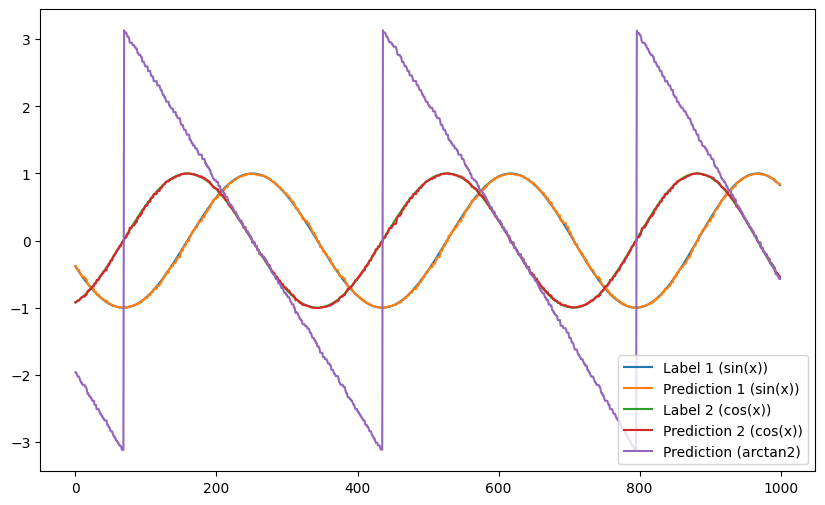

In [13]:
import matplotlib.pyplot as plt
import numpy as np

train_batch = iter(dataloader)

with torch.no_grad():
    labels1 = []
    labels2 = []
    predictions1 = []
    predictions2 = []
    arctan_predictions = []
    for _ in range(10):
        batch = next(train_batch)
        feature, label = batch
        feature = feature.to(device, dtype=torch.float32)
        label = label.to(device)
        output, mem = model(feature)
        labels1.append(label[:, 0].cpu().numpy())
        labels2.append(label[:, 1].cpu().numpy())
        predictions1.append(mem[:, 0].cpu().numpy())
        predictions2.append(mem[:, 1].cpu().numpy())
        arctan_predictions.append(np.arctan2(mem[:, 1].cpu().numpy(), mem[:, 0].cpu().numpy()))

    # Plot label and prediction
    plt.figure(figsize=(10, 6))
    plt.plot(np.concatenate(labels1), label='Label 1 (sin(x))')
    plt.plot(np.concatenate(predictions1), label='Prediction 1 (sin(x))')
    plt.plot(np.concatenate(labels2), label='Label 2 (cos(x))')
    plt.plot(np.concatenate(predictions2), label='Prediction 2 (cos(x))')
    plt.plot(np.concatenate(arctan_predictions), label='Prediction (arctan2)')
    plt.legend()
    plt.show()


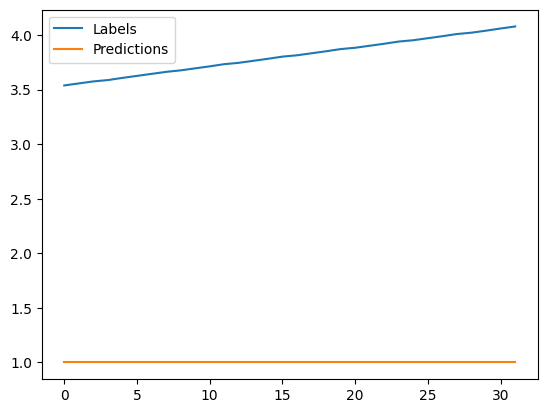

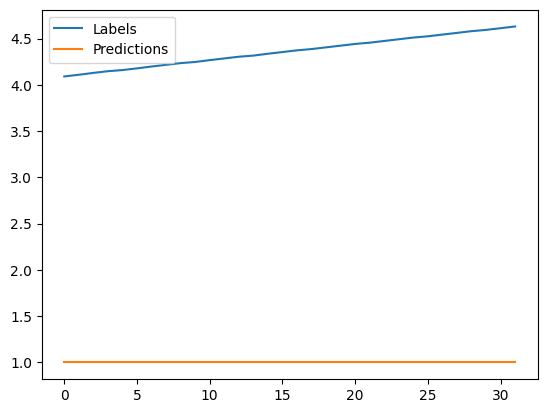

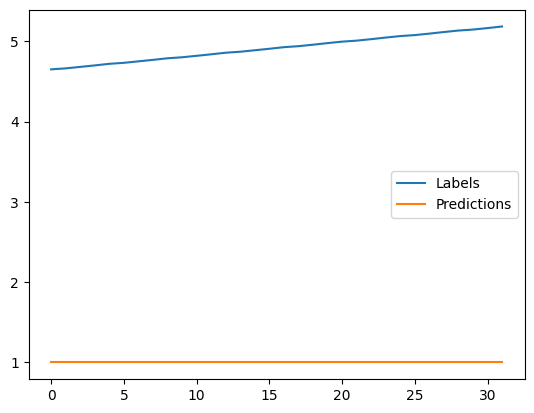

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('data.csv')

# Get the input features and the label
input_features = data.iloc[:, :12].values.astype(np.float32)
label = data.iloc[:, 12].values.astype(np.float32)

# Reshape the label to match the output shape of the model
label = label.reshape((input_features.shape[0], 1))

# Split the data into training, testing, and validation sets
train_features, val_test_features, train_labels, val_test_labels = train_test_split(input_features, label, test_size=0.4, random_state=42)
val_features, test_features, val_labels, test_labels = train_test_split(val_test_features, val_test_labels, test_size=0.5, random_state=42)

# Create custom dataset instances for each set
train_dataset = CustomDataset(train_features, train_labels)
val_dataset = CustomDataset(val_features, val_labels)
test_dataset = CustomDataset(test_features, test_labels)

# Create DataLoader instances for each set
batch_size = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, drop_last=True)

# Import a set of continuous rows
continuous_rows = 100
continuous_features = input_features[:continuous_rows, :]
continuous_labels = label[:continuous_rows, :]

# Create a custom dataset instance for the continuous rows
continuous_dataset = CustomDataset(continuous_features, continuous_labels)

# Create a DataLoader instance for the continuous rows
continuous_dataloader = DataLoader(dataset=continuous_dataset, batch_size=batch_size, drop_last=True)

# Use the continuous rows to predict and plot


# Use the continuous rows to predict and plot
continuous_batch = iter(continuous_dataloader)

with torch.no_grad():
    for _ in range(len(continuous_dataloader)):
        batch = next(continuous_batch)
        features, labels = batch
        features = features.to(device, dtype=torch.float32)
        labels = labels.to(device)
        outputs, _ = model(features)
        predictions = outputs.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.plot(labels, label='Labels')
        plt.plot(predictions, label='Predictions')
        plt.legend()
        plt.show()

In [16]:
import numpy as np

# Create a numpy array with the 12 values
input_values = np.array([
    0.400165915, -1.274127364, 0.057144079, -0.1130144,
    0.431862235, -1.264977455, 0.060369313, -0.111537278,
    0.459596455, -1.244390249, 0.059304267, -0.111418493
]).reshape(1, 12)

# Make a prediction with the model
input_values = torch.tensor(input_values, dtype=torch.float32).to(device)
output, mem = model(input_values)

# Print the prediction
print("Prediction:", mem)


Prediction: tensor([[-0.3794, -0.9194]], device='cuda:0', grad_fn=<AddBackward0>)


In [15]:
# Get the weights of the model
layer1_weights = model.fc1.weight.detach().cpu().numpy().flatten()
layer2_weights = model.fc2.weight.detach().cpu().numpy().flatten()

# Store the weights in a text file
with open("weights.txt", "w") as f:
    f.write("const float weights_layer1[{}] = {{\n".format(len(layer1_weights)))
    for i in range(len(layer1_weights)):
        f.write("  {:.6f}".format(layer1_weights[i]))
        if i < len(layer1_weights) - 1:
            f.write(",")
       # f.write("\n")
    f.write("};\n")

    f.write("const float weights_layer2[{}] = {{\n".format(len(layer2_weights)))
    for i in range(len(layer2_weights)):
        f.write("  {:.6f}".format(layer2_weights[i]))
        if i < len(layer2_weights) - 1:
            f.write(",")
       # f.write("\n")
    f.write("};\n")


Let's plot our results for some visual intuition:

It is a little jagged, but it's not looking too bad.

You might try to improve the curve fit by expanding the size of the hidden layer, increasing the number of iterations, adding extra time steps, hyperparameter fine-tuning, or using a completely different neuron type.

# Conclusion

The next regression tutorials will test more powerful spiking neurons, such as Recurrent LIF neurons and spiking LSTMs, to see how they compare.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.


# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* More detail on nonlinear regression with SNNs can be found in our corresponding preprint here: [Henkes, A.; Eshraghian, J. K.; and Wessels, H.  “Spiking neural networks for nonlinear regression", arXiv preprint arXiv:2210.03515, Oct. 2022.](https://arxiv.org/abs/2210.03515)